In [132]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

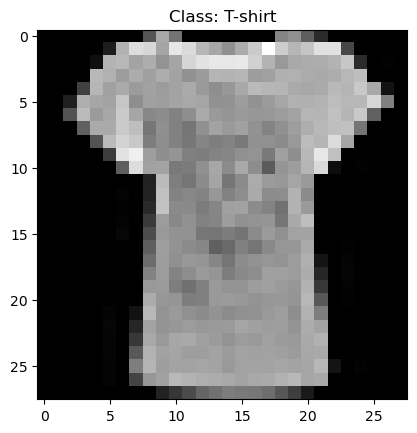

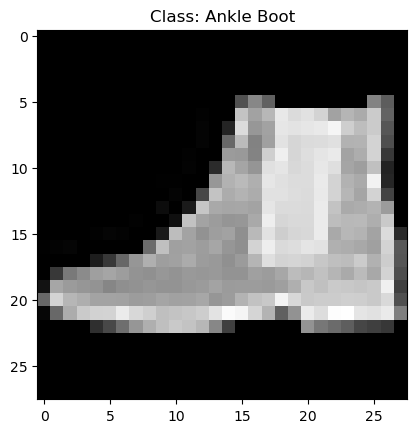

In [264]:
# Load Fashion MNIST dataset
fashion_mnist = fetch_openml("Fashion-MNIST", version=1)

# Extract the data and labels
X = fashion_mnist.data
y = fashion_mnist.target.astype(int)

# For binary classification, let's select two classes: T-shirt and Ankle boot (for example)
class_1, class_2 = 0, 9  # T-shirt and Ankle Boot
binary_filter = np.isin(y, [class_1, class_2])

# Filter the dataset for only the two classes
X_binary = X[binary_filter]
y_binary = y[binary_filter]

# Normalize the data to range [0, 1]
X_binary = X_binary / 255.0

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_binary, y_binary, test_size=0.2, random_state=42)

# Visualize a sample image from the dataset
plt.imshow(X_train.iloc[3].values.reshape(28, 28), cmap="gray")
plt.title(f"Class: {'T-shirt' if y_train.iloc[3] == class_1 else 'Ankle Boot'}")
plt.show()

plt.imshow(X_train.iloc[11].values.reshape(28, 28), cmap="gray")
plt.title(f"Class: {'T-shirt' if y_train.iloc[11] == class_1 else 'Ankle Boot'}")
plt.show()
#print(f"Shape of training data: {X_train.shape}")
#print(f"Shape of testing data: {X_test.shape}")

In [265]:
# Explore your dataset 
m_train = X_train.shape[0]
num_px = X_train.shape[1]
m_test = X_test.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(X_train.shape))
print ("train_y shape: " + str(y_train.shape))
print ("test_x_orig shape: " + str(X_train.shape))
print ("test_y shape: " + str(y_test.shape))

Number of training examples: 11200
Number of testing examples: 2800
Each image is of size: (784, 784, 3)
train_x_orig shape: (11200, 784)
train_y shape: (11200,)
test_x_orig shape: (11200, 784)
test_y shape: (2800,)


In [266]:
train_x_orig = X_train.to_numpy()
test_x_orig = X_test.to_numpy()

y_train = np.array(y_train).reshape(1, -1)
y_test = np.array(y_test).reshape(1, -1)

y_train = np.where(y_train == 9, 1, y_train)  # Sostituisci 9 con 1
y_test = np.where(y_test == 9, 1, y_test)    # Sostituisci 9 con 1


In [267]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (784, 11200)
test_x's shape: (784, 2800)


In [347]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 784  #num_px * num_px *3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.0075

In [349]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Initializes parameters W1, b1, W2, and b2 for a two-layer neural network.

    Arguments:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer

    Returns:
    parameters -- a dictionary containing:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    np.random.seed(1)  # Ensures reproducibility

    W1 = np.random.randn(n_h, n_x) * 0.01  # Small random values
    b1 = np.zeros((n_h, 1))  # Initialized as zeros
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    
    return parameters


In [351]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implements the forward propagation for the LINEAR -> ACTIVATION step.

    Arguments:
    A_prev -- activations from previous layer (or input data), shape (size of previous layer, number of examples)
    W -- weights matrix, shape (size of current layer, size of previous layer)
    b -- bias vector, shape (size of current layer, 1)
    activation -- the activation function to use ("sigmoid" or "relu")

    Returns:
    A -- output of the activation function
    cache -- a tuple (linear_cache, activation_cache) stored for computing backward pass efficiently
    """

    def sigmoid(Z):
        return 1 / (1 + np.exp(-Z)), Z  # Returning Z as cache for backward propagation

    def relu(Z):
        return np.maximum(0, Z), Z  # Returning Z as cache for backward propagation

    # Linear step
    Z = np.dot(W, A_prev) + b  # Z = W.A_prev + b
    linear_cache = (A_prev, W, b)  # Store for backward propagation

    # Activation step
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        A, activation_cache = relu(Z)
    else:
        raise ValueError("Unsupported activation function: Use 'relu' or 'sigmoid'")

    cache = (linear_cache, activation_cache)  # Store for backward pass

    return A, cache


In [353]:
def linear_activation_backward(dA, cache, activation):
    """
    Implements the backward propagation for the LINEAR->ACTIVATION layer.

    Arguments:
    dA -- post-activation gradient for current layer
    cache -- tuple containing (linear_cache, activation_cache)
    activation -- activation function used in this layer ("relu" or "sigmoid")

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation of the previous layer
    dW -- Gradient of the cost with respect to W (same shape as W)
    db -- Gradient of the cost with respect to b (same shape as b)
    """
    
    linear_cache, activation_cache = cache  # Unpack the caches
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
    else:
        raise ValueError("Unsupported activation function")

    dA_prev, dW, db = linear_backward(dZ, linear_cache)  # Compute gradients
    return dA_prev, dW, db


In [355]:
def compute_cost(A2, Y):
    """
    Implements the cross-entropy cost function.

    Arguments:
    A2 -- post-activation, output of the second layer (prediction)
    Y -- true labels

    Returns:
    cost -- cross-entropy cost
    """
    epsilon = 1e-15  # A small value to avoid log(0)
    A2 = np.clip(A2, epsilon, 1 - epsilon)  # Limit values of A2 between epsilon and 1-epsilon
    #print(np.min(A2), np.max(A2))
    #print(np.unique(Y))  # Verifica che le etichette siano solo 0 o 1
    m = Y.shape[1]  # Number of examples
    cost = (-1 / m) * np.sum(Y * np.log(A2) + (1 - Y) * np.log(1 - A2))
    cost = np.squeeze(cost)  # Ensure cost is a scalar value
    return cost


In [357]:
def sigmoid_backward(dA, cache):
    """
    Implements the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- stored Z value from forward propagation

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    Z = cache
    A = 1 / (1 + np.exp(-Z))  # Compute sigmoid activation
    dZ = dA * A * (1 - A)  # Compute derivative
    return dZ


In [359]:
def linear_backward(dZ, cache):
    """
    Implements the backward propagation for the LINEAR part of a layer.

    Arguments:
    dZ -- Gradient of the cost with respect to Z (output of activation function)
    cache -- Tuple containing (A_prev, W, b) from forward propagation

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation of the previous layer
    dW -- Gradient of the cost with respect to W
    db -- Gradient of the cost with respect to b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]  # Number of examples

    dW = (1 / m) * np.dot(dZ, A_prev.T)  # Compute gradient of W
    db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)  # Compute gradient of b
    dA_prev = np.dot(W.T, dZ)  # Compute gradient of A_prev

    return dA_prev, dW, db


In [361]:
def relu_backward(dA, cache):
    """
    Implements the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- stored Z value from forward propagation

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    Z = cache
    dZ = np.array(dA, copy=True)  # Copy the post-activation gradient
    dZ[Z <= 0] = 0  # Set gradients to 0 where Z is less than or equal to 0
    return dZ


In [363]:
def update_parameters(parameters, grads, learning_rate):
    """
    Aggiorna i pesi e i bias utilizzando il gradiente discesa.

    Arguments:
    parameters -- dizionario che contiene W1, b1, W2, b2
    grads -- dizionario che contiene i gradienti dW1, db1, dW2, db2
    learning_rate -- tasso di apprendimento

    Returns:
    parameters -- dizionario che contiene i parametri aggiornati
    """
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    # Aggiornamenti dei parametri
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2

    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return parameters


In [365]:
# GRADED FUNCTION: two_layer_model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.001, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    #(≈ 1 line of code)
    # parameters = ...
    # YOUR CODE STARTS HERE
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # YOUR CODE ENDS HERE
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        
        cost = compute_cost(A2, Y)

        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 iterations and for the last iteration
        if print_cost and (i % 100 == 0 or i == num_iterations - 1):
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0:
            costs.append(cost)
            
    return parameters, costs

def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

In [367]:
parameters, costs = two_layer_model(train_x, y_train, layers_dims = (n_x, n_h, n_y), num_iterations = 2, print_cost=False)

print("Cost after first iteration: " + str(costs[0]))


Cost after first iteration: 0.6931444096091988


Cost after iteration 0: 0.6931444096091988
Cost after iteration 100: 0.6931436169375578
Cost after iteration 200: 0.693143117008975
Cost after iteration 300: 0.6931427174499007
Cost after iteration 400: 0.6931423559477036
Cost after iteration 500: 0.6931420189712086
Cost after iteration 600: 0.6931417011353597
Cost after iteration 700: 0.6931413997857766
Cost after iteration 800: 0.6931411130388374
Cost after iteration 900: 0.6931408397351211
Cost after iteration 1000: 0.69314057906012
Cost after iteration 1100: 0.6931403301015396
Cost after iteration 1200: 0.693140091830452
Cost after iteration 1300: 0.6931398633228885
Cost after iteration 1400: 0.6931396440597686
Cost after iteration 1500: 0.6931394325006031
Cost after iteration 1600: 0.6931392279538994
Cost after iteration 1700: 0.6931390294555119
Cost after iteration 1800: 0.6931388364599276
Cost after iteration 1900: 0.6931386508783188
Cost after iteration 2000: 0.6931384731791314
Cost after iteration 2100: 0.6931383035119213
Cost

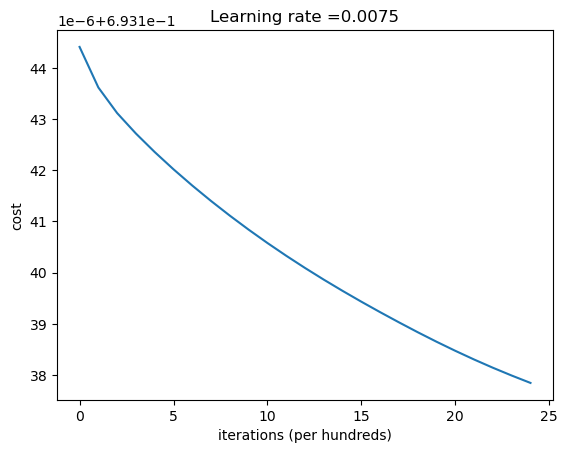

In [371]:
parameters, costs = two_layer_model(train_x, y_train, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)
plot_costs(costs, learning_rate)

Cost after iteration 0: 0.6931444096091988
Cost after iteration 100: 0.6931436169375578
Cost after iteration 200: 0.693143117008975
Cost after iteration 300: 0.6931427174499007
Cost after iteration 400: 0.6931423559477036
Cost after iteration 500: 0.6931420189712086
Cost after iteration 600: 0.6931417011353597
Cost after iteration 700: 0.6931413997857766
Cost after iteration 800: 0.6931411130388374
Cost after iteration 900: 0.6931408397351211
Cost after iteration 1000: 0.69314057906012
Cost after iteration 1100: 0.6931403301015396
Cost after iteration 1200: 0.693140091830452
Cost after iteration 1300: 0.6931398633228885
Cost after iteration 1400: 0.6931396440597686
Cost after iteration 1500: 0.6931394325006031
Cost after iteration 1600: 0.6931392279538994
Cost after iteration 1700: 0.6931390294555119
Cost after iteration 1800: 0.6931388364599276
Cost after iteration 1900: 0.6931386508783188
Cost after iteration 2000: 0.6931384731791314
Cost after iteration 2100: 0.6931383035119213
Cost

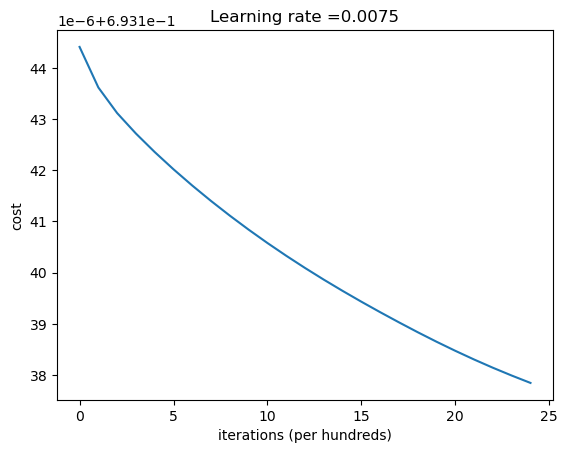

In [373]:
parameters, costs = two_layer_model(train_x, y_train, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)
plot_costs(costs, learning_rate)

In [374]:
def predict(X, Y, parameters):
    """
    Predicts the labels for the input data X using the trained parameters.
    
    Arguments:
    X -- input data (features)
    Y -- true labels (for evaluation)
    parameters -- trained parameters of the model (W1, b1, W2, b2)
    
    Returns:
    predictions -- the predicted labels (0 or 1)
    """

    # Retrieve the parameters
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Forward propagation (linear -> ReLU -> linear -> Sigmoid)
    A1, _ = linear_activation_forward(X, W1, b1, "relu")
    A2, _ = linear_activation_forward(A1, W2, b2, "sigmoid")
    
    # Make predictions: if A2 > 0.5, predict 1, else 0
    predictions = (A2 > 0.5).astype(int)
    
    # Optionally: calculate the accuracy (if needed)
    accuracy = np.mean(predictions == Y)
    print(f"Accuracy: {accuracy * 100}%")
    
    return predictions


In [379]:
predictions_train = predict(train_x, y_train, parameters)

Accuracy: 50.19642857142858%


In [389]:
def initialize_parameters_deep(layers_dims):
    """
    Initializes parameters for a deep L-layer neural network.
    
    Arguments:
    layers_dims -- list containing the size of each layer in the network.
    
    Returns:
    parameters -- dictionary containing the initialized parameters (W1, b1, ..., WL, bL).
    """
    np.random.seed(1)
    parameters = {}
    L = len(layers_dims)  # Number of layers in the neural network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
    
    return parameters


In [395]:
def L_model_forward(X, parameters):
    """
    Implements forward propagation for the entire L-layer neural network.
    
    Arguments:
    X -- input data
    parameters -- dictionary containing the parameters (W1, b1, ..., WL, bL)
    
    Returns:
    AL -- final activation output
    caches -- list of caches containing every cache of each layer
    """
    caches = []
    A = X
    L = len(parameters) // 2  # Number of layers
    
    # Loop over all layers
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)
    
    # Output layer: Linear -> Sigmoid
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    caches.append(cache)
    
    return AL, caches


In [399]:
def L_model_backward(AL, Y, caches):
    """
    Implements backward propagation for the entire L-layer neural network.
    
    Arguments:
    AL -- final activation output
    Y -- true labels
    caches -- list of caches from forward propagation
    
    Returns:
    grads -- dictionary containing the gradients with respect to each parameter
    """
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    # Backward pass for the output layer
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")
    
    # Loop backward through the layers
    for l in range(L-2, -1, -1):
        current_cache = caches[l]
        grads["dA" + str(l+1)], grads["dW" + str(l+1)], grads["db" + str(l+1)] = linear_activation_backward(grads["dA" + str(l+2)], current_cache, "relu")
    
    return grads


In [391]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)
        
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
                
        # Compute cost.
        cost = compute_cost(AL, Y)    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
         
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                        
        # Print the cost every 100 iterations and for the last iteration
        if print_cost and (i % 100 == 0 or i == num_iterations - 1):
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0:
            costs.append(cost)
    
    return parameters, costs

Cost after first iteration: 0.6931444096091988
Cost after iteration 0: 0.6931444096091988
Cost after iteration 100: 0.6931412528383982
Cost after iteration 200: 0.6931394306306902
Cost after iteration 300: 0.6931380638096449
Cost after iteration 400: 0.6931371303154747
Cost after iteration 500: 0.693136483793627
Cost after iteration 600: 0.6931360101635854
Cost after iteration 700: 0.6931356535012512
Cost after iteration 800: 0.6931353767697839
Cost after iteration 900: 0.6931351547227198
Cost after iteration 1000: 0.6931349699939686
Cost after iteration 1100: 0.6931348105903256
Cost after iteration 1200: 0.6931346682914635
Cost after iteration 1300: 0.6931345373917744
Cost after iteration 1400: 0.6931344139902248
Cost after iteration 1500: 0.6931342953732634
Cost after iteration 1600: 0.6931341797325503
Cost after iteration 1700: 0.6931340657419736
Cost after iteration 1800: 0.693133952445889
Cost after iteration 1900: 0.6931338391932993
Cost after iteration 2000: 0.6931337254494424
C

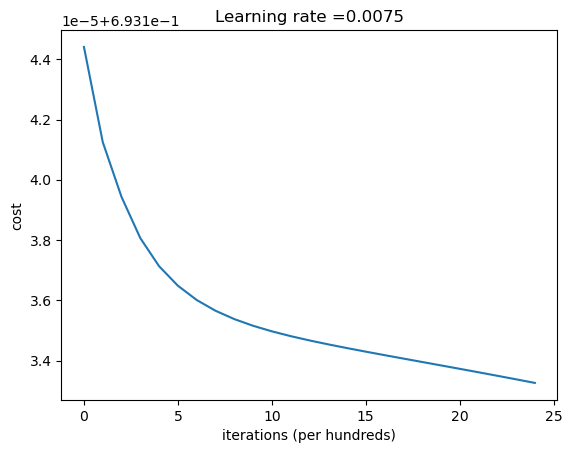

In [403]:
parameters, costs = L_layer_model(train_x, y_train, layers_dims, num_iterations = 1, print_cost = False)

print("Cost after first iteration: " + str(costs[0]))

parameters, costs = L_layer_model(train_x, y_train, layers_dims , num_iterations = 2500, print_cost=True)
plot_costs(costs, learning_rate)